# Import packages

In [4]:
from utils import *
from metrics import *
import time
import os

# algorithms
from pymoo.algorithms.soo.nonconvex.cmaes import CMAES
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.core.problem import Problem

from pymoo.factory import get_termination
from pymoo.util.termination import collection


# Reference image

In [5]:
image_path = 'input_data/01019-s1-1.png'
ground_truth = getTargetImage(image_path,0,log=False)

print(ground_truth.shape)

(1024, 768)


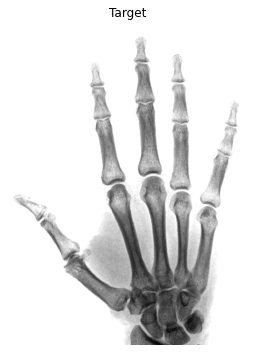

In [6]:
plt.figure(figsize= (5,5))
plt.title("Target")
plt.imshow(ground_truth, cmap='gray')
plt.axis('off')

plt.tight_layout()


In [7]:
log_ground_truth = getTargetImage(image_path,0,log=True)

# use log image
ground_truth = log_ground_truth

# 3D hand model

In [8]:
hand_model = plt.imread('input_data/hand_model.png')

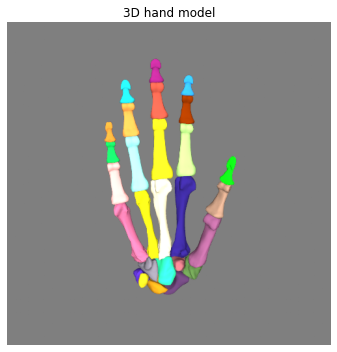

In [9]:
plt.figure(figsize= (10,5))
plt.title("3D hand model")
plt.imshow(hand_model)
plt.axis('off')

plt.tight_layout()

# Set X-ray simulation parameters

In [10]:
model_path = 'input_data/hand.dae'

setXRayEnvironment(model_path,0) 

In [11]:
x_ray_image = np.array(gvxr.computeXRayImage())
x_ray_image = (x_ray_image-x_ray_image.mean())/x_ray_image.std()

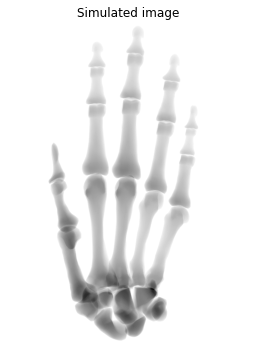

In [12]:
plt.figure(figsize= (10,5))
plt.title("Simulated image")
plt.imshow(x_ray_image, cmap='gray')
plt.axis('off')

plt.tight_layout()

In [13]:
# gvxr.displayScene()


In [14]:
# gvxr.renderLoop()

# CMA-ES

# NSGA-II

In [15]:
# setting up parameters
xl = np.array([0.7, 10., -20., -20., -20.,
            -10., -20., -10.,
            -10., -20., -20., -20.,
            -10., -20., -20., -20.,
            -10., -20., -20. ,-20.,
            -10., -20., -20., -20.,
            0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9])

xu = np.array([0.95, 1000., 20., 20., 20.,
            10., 0., 0.,
            10., 0., 0., 0.,
            10., 0., 0., 0.,
            10., 0., 0., 0.,
            10., 0., 0., 0.,
            1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1])

In [16]:
def objectiveFunction(aPrediction):

    obj_list = []

    for i in aPrediction:

        pred_image = computePredictedImage(i)
        row = []

        obj1 = nzncc(ground_truth, pred_image)
        row.append(obj1)
        
        obj2 = nssim(ground_truth, pred_image)
        row.append(obj2)

        obj3 = mae(ground_truth, pred_image)
        row.append(obj3)

        obj4 = rmse(ground_truth, pred_image)
        row.append(obj4)

        obj5 = nmi(ground_truth, pred_image)
        row.append(obj5)
        
        obj_list.append(row)


    return obj_list

In [17]:
class multiObjectiveProblem(Problem):

    def __init__(self):
        super().__init__(n_var=38, 
                         n_obj=5, 
                         n_constr=0, 
                         xl=xl,
                         xu=xu)


    def _evaluate(self, x, out, *args, **kwargs):

        out["F"] = np.array(objectiveFunction(x))
        

In [18]:
problem = multiObjectiveProblem()

pop_size = 100

x_tol_termination = get_termination("x_tol", 1e-5)
f_tol_termination = get_termination("f_tol", 1e-5)
time_termination = get_termination("time", "00:20:00")

termination = collection.TerminationCollection(x_tol_termination, f_tol_termination, time_termination)

if False: #os.path.exists("output_data/nsga2-X.dat") and os.path.exists("output_data/nsga2-F.dat"):

    res_nsga2_X = np.loadtxt("output_data/nsga2-X.dat")
    res_nsga2_F = np.loadtxt("output_data/nsga2-F.dat")

else:

    algorithm = NSGA2(
        pop_size=pop_size,
        eliminate_duplicates=True)

    res_nsga2 = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   save_history=True,
                   verbose=True)

    res_nsga2_X = res_nsga2.X
    res_nsga2_F = res_nsga2.F

    np.savetxt("output_data/nsga2-X.dat", res_nsga2_X)
    np.savetxt("output_data/nsga2-F.dat", res_nsga2_F)

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |     100 |       5 |            - |            -
    2 |     200 |       5 |  0.135308098 |        ideal
    3 |     300 |       5 |  0.544567551 |        ideal
    4 |     400 |       7 |  0.206513651 |        ideal
    5 |     500 |       4 |  0.826692634 |        ideal
    6 |     600 |       6 |  0.146840887 |        ideal
    7 |     700 |       9 |  0.144421870 |            f
    8 |     800 |      12 |  0.344617285 |        ideal
    9 |     900 |       3 |  0.446872255 |        ideal
   10 |    1000 |       5 |  0.429262894 |        ideal
   11 |    1100 |       8 |  0.177528105 |        ideal
   12 |    1200 |       9 |  0.074444298 |        ideal
   13 |    1300 |       5 |  0.389361117 |        ideal
   14 |    1400 |       7 |  0.015316351 |        ideal
   15 |    1500 |       2 |  0.416507558 |        ideal
   16 |    1600 |       5 |  0.649653592 |        ideal
   17 |    1700 |       9 |  0.094731653 |      

In [19]:
best_nzncc_id = np.argmin(res_nsga2_F[:,0])
best_nssim_id = np.argmin(res_nsga2_F[:,1])
best_mae_id = np.argmin(res_nsga2_F[:,2])
best_rmse_id = np.argmin(res_nsga2_F[:,3])
best_nmi_id = np.argmin(res_nsga2_F[:,4])

print("Lowest NZNCC:", res_nsga2_F[:,0].min(), best_nzncc_id, res_nsga2_X[best_nzncc_id])
print("Lowest NSSIM:", res_nsga2_F[:,1].min(), best_nssim_id, res_nsga2_X[best_nssim_id])
print("Lowest MAE:",   res_nsga2_F[:,2].min(), best_mae_id,   res_nsga2_X[best_mae_id])
print("Lowest RMSE:",  res_nsga2_F[:,3].min(), best_rmse_id,  res_nsga2_X[best_rmse_id])
print("Lowest NMI:",  res_nsga2_F[:,4].min(), best_nmi_id,  res_nsga2_X[best_nmi_id])

Lowest NZNCC: -0.6573336398036588 2 [  0.81806411 332.61508827 -19.98185128  -4.29953259 -11.64095873
  -9.89925631  -2.20147672  -9.15367232   1.30383715  -4.07998002
 -16.53361499 -12.69827779  -3.09212205 -19.20267367 -19.68995522
 -11.36271305   6.64011015  -3.05889457  -2.83557229  -5.89921865
   9.38216389 -10.52349966  -6.1981181   -1.38363862   0.95940536
   0.9531895    0.90353936   0.90259358   0.95293553   0.90114402
   0.90255039   0.91482359   1.01286839   0.92747166   0.92768399
   1.06355735   1.02659335   1.05473212]
Lowest NSSIM: -0.6181652353752196 4 [  0.85206679 728.16361158 -19.95530819  -4.3262677  -11.34993463
   9.78748456  -5.44739886  -6.92829076   0.81176702 -19.59795414
 -18.87675248 -12.96836538  -3.4549413  -19.52937175 -19.82281699
 -11.03309908   6.69201116  -2.76078048  -3.584096    -5.68314253
   9.35295161 -10.52806438  -4.84652015  -3.03670152   0.95485462
   0.95271902   0.90148158   0.90106636   0.94833892   0.9102209
   0.92434792   0.91726667   1

In [20]:
xray_image_nzncc_nsga2 = computePredictedImage(res_nsga2_X[best_nzncc_id])
xray_image_nssim_nsga2   = computePredictedImage(res_nsga2_X[best_nssim_id])
xray_image_mae_nsga2  = computePredictedImage(res_nsga2_X[best_mae_id])
xray_image_rmse_nsga2 = computePredictedImage(res_nsga2_X[best_rmse_id])
xray_image_nmi_nsga2  = computePredictedImage(res_nsga2_X[best_nmi_id])

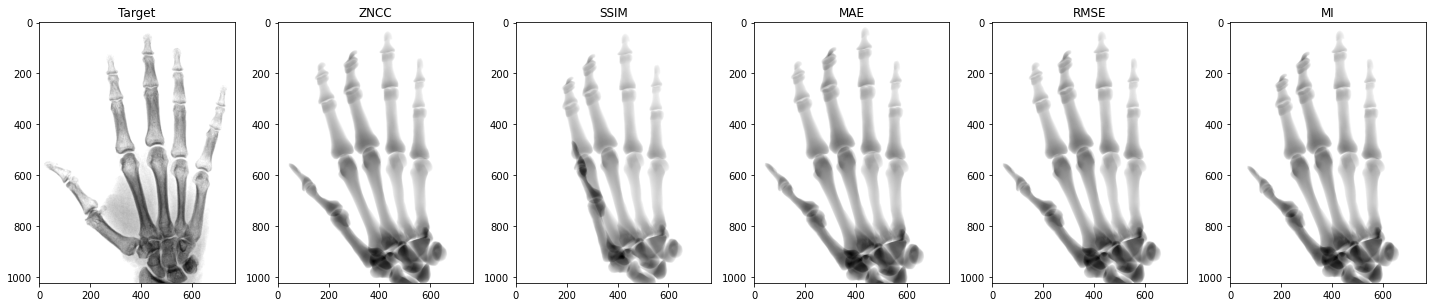

In [21]:
plt.figure(figsize= (20,10))

# plt.suptitle("Results")

plt.subplot(161)
plt.imshow(ground_truth, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("Target")

plt.subplot(162)
plt.imshow(xray_image_nzncc_nsga2, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("ZNCC")

plt.subplot(163)
plt.imshow(xray_image_nssim_nsga2, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("SSIM")

plt.subplot(164)
plt.imshow(xray_image_mae_nsga2, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("MAE")

plt.subplot(165)
plt.imshow(xray_image_rmse_nsga2, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("RMSE")

plt.subplot(166)
plt.imshow(xray_image_nmi_nsga2, cmap="gray")
# plt.colorbar(orientation='horizontal')
plt.title("MI")

plt.tight_layout()

# plt.savefig(fname + '.pdf')
# plt.savefig(fname + '.png')